# **Downloading Dependencies**

In [1]:
%pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.4 MB/s eta 0:00:00


# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [20]:
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# **Importing data and preprocessing it**

In [3]:
df = pd.read_csv('NESTLE_Pakistan_Stocks.csv')

In [4]:
df.head()

,Unnamed: 0,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME
0,0,2021-01-29,6979.00,6987.50,6450.0,6470.0,360
1,1,2021-01-27,6519.45,6520.00,6500.0,6500.0,60
2,2,2021-01-26,6413.81,6470.00,6400.0,6470.0,220
3,3,2021-01-25,6502.00,6523.99,6400.0,6420.0,520
4,4,2021-01-22,6620.00,6620.00,6575.0,6575.0,80


In [5]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [6]:
# Making date columns as index
df.set_index('DATE', inplace= True)

In [7]:
df.head()

,Unnamed: 0,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE,,,,,,
2021-01-29,0,6979.00,6987.50,6450.0,6470.0,360
2021-01-27,1,6519.45,6520.00,6500.0,6500.0,60
2021-01-26,2,6413.81,6470.00,6400.0,6470.0,220
2021-01-25,3,6502.00,6523.99,6400.0,6420.0,520
2021-01-22,4,6620.00,6620.00,6575.0,6575.0,80


In [8]:
# sorting index
df.sort_index(inplace= True)

In [9]:
df.head()

,Unnamed: 0,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE,,,,,,
2021-01-01,15,6670.0,6674.99,6503.11,6627.50,140
2021-01-04,14,6750.0,6750.00,6700.00,6700.00,80
2021-01-08,13,6800.0,6838.00,6702.11,6807.09,360
2021-01-11,12,6800.0,6800.00,6700.00,6770.00,640
2021-01-12,11,6683.0,6683.00,6631.50,6660.40,100


In [10]:
df.drop(['Unnamed: 0', 'VOLUME'], inplace= True, axis= 1)

In [11]:
df.head()

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
2021-01-01,6670.0,6674.99,6503.11,6627.50
2021-01-04,6750.0,6750.00,6700.00,6700.00
2021-01-08,6800.0,6838.00,6702.11,6807.09
2021-01-11,6800.0,6800.00,6700.00,6770.00
2021-01-12,6683.0,6683.00,6631.50,6660.40


In [12]:
# Focus on 'Close' price
data = df[['CLOSE']].values

In [13]:
# Normalizing the dataset
scaler = MinMaxScaler()

scaled_values = scaler.fit_transform(data)

In [14]:
scaled_df = pd.DataFrame(scaled_values, columns = ['CLOSE'], index= df.index)

In [15]:
scaled_df.head()

,CLOSE
DATE,
2021-01-01,0.436803
2021-01-04,0.454771
2021-01-08,0.481311
2021-01-11,0.472119
2021-01-12,0.444957


# **Visualization**

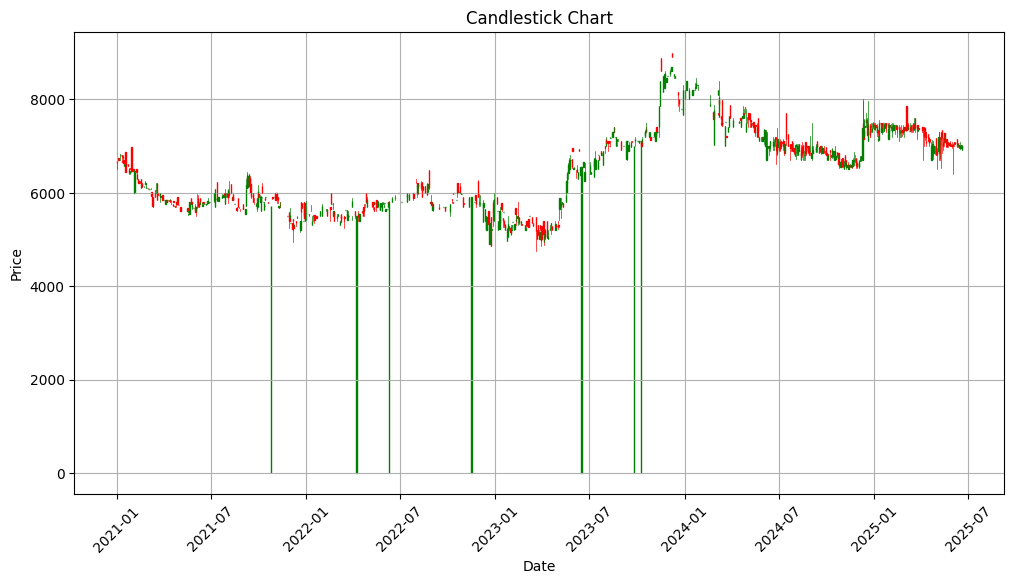

In [16]:
# Candlestick Chart
matplotlib_date = mdates.date2num(df.index)

ohlc = np.vstack((matplotlib_date, df['OPEN'], df['HIGH'], df['LOW'], df['CLOSE'])).T

plt.figure(figsize=(12, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# **Training Model**

In [17]:
# Creating slide back windows
def create_sequence(data, window_size):
  X = []
  y = []

  for i in range(window_size, len(data)):
    X.append(data.iloc[i - window_size: i].values)
    y.append(data.iloc[i].values)

  return np.array(X), np.array(y)

In [18]:
X, y = create_sequence(scaled_df, 60)

In [19]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [21]:
(X_train.shape[1], X_train.shape[2])

(60, 1)

**Defining Model Architecture**

In [22]:
model = Sequential([
    LSTM(units= 50, return_sequences= True, input_shape= (X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units= 50, return_sequences= True),
    Dropout(0.2),
    LSTM(units= 50, return_sequences= False),
    Dropout(0.2),

    Dense(y_train.shape[1])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.compile(optimizer= 'adam', loss= 'mse', metrics= ['RootMeanSquaredError'])

In [24]:
# Early stopping
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10, restore_best_weights= True)

In [25]:
history = model.fit(X_train, y_train, epochs= 100, batch_size= 32, validation_split= 0.2, callbacks= early_stopping)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - RootMeanSquaredError: 0.3201 - loss: 0.1080 - val_RootMeanSquaredError: 0.1327 - val_loss: 0.0176
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - RootMeanSquaredError: 0.1348 - loss: 0.0187 - val_RootMeanSquaredError: 0.0640 - val_loss: 0.0041
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - RootMeanSquaredError: 0.0819 - loss: 0.0067 - val_RootMeanSquaredError: 0.0504 - val_loss: 0.0025
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - RootMeanSquaredError: 0.0804 - loss: 0.0065 - val_RootMeanSquaredError: 0.0493 - val_loss: 0.0024
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - RootMeanSquaredError: 0.0768 - loss: 0.0059 - val_RootMeanSquaredError: 0.0498 - val_loss: 0.0025
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - RootMeanSquaredError: 0.0780 - loss: 0.0061 - val_RootMeanSquaredError: 0.0479 - val_loss: 0.0023
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - RootMeanSquaredError: 0.0783 - los

**Weights of trained model**

In [26]:
model.get_weights()

[array([[ 2.36612037e-01,  9.84898396e-03, -8.16336200e-02,
          4.90603805e-01,  1.55129179e-01,  9.97961015e-02,
         -2.64793411e-02,  2.17422426e-01,  2.31025368e-01,
         -9.20845866e-02,  1.42188609e-01,  1.14810042e-01,
          3.58505666e-01,  3.24693620e-02,  2.92129684e-02,
          1.41427740e-01, -2.36029457e-02,  8.84112045e-02,
         -6.16881847e-02,  1.28788903e-01, -5.26746139e-02,
         -9.14095268e-02, -5.01387939e-02,  3.21621522e-02,
          1.01660565e-01, -1.86009910e-02,  1.72323003e-01,
          1.20259665e-01,  7.95995723e-03,  2.54019201e-01,
          1.68575764e-01, -7.85746798e-02,  8.47795382e-02,
          1.00877792e-01,  8.78956765e-02,  1.89957887e-01,
          1.34282047e-02,  6.78584129e-02,  9.55006778e-02,
          9.28974748e-02,  2.22355455e-01,  7.85041228e-02,
          6.65767724e-03,  1.45153388e-01, -1.09069698e-01,
         -4.69512157e-02,  7.44521022e-02, -6.12847693e-02,
         -1.13928542e-01, -2.30766163e-0

# **Testing the model**

In [31]:
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


In [32]:
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

In [37]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = root_mean_squared_error(y_test_rescaled, y_pred_rescaled)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 31021.491526317168
RMSE: 176.12918987583282


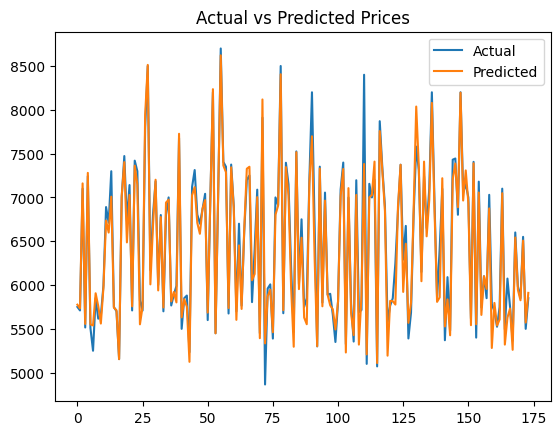

In [39]:
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.show()

# **Predictions**

In [40]:
# Get the last 60 days from scaled_df as starting input
last_60 = scaled_df[-60:].values
predicted = []

# Predict next 650 time steps (days)
for _ in range(650):
    seq_input = last_60[-60:].reshape(1, 60, 1)  # Shape: (1, 60, 1)
    next_val = model.predict(seq_input, verbose=0)  # Output shape: (1, 1)
    predicted.append(next_val[0][0])  # Save the single predicted value
    last_60 = np.vstack([last_60, next_val])[-60:]  # Append to sliding window

# Convert predictions to array
predicted = np.array(predicted).reshape(-1, 1)  # Shape: (650, 1)

# Inverse transform to original scale
predicted_prices = scaler.inverse_transform(predicted)  # Shape: (650, 1)

# Create future date range starting from the last date in original df
last_date = scaled_df.index[-1]  # e.g., 2024-10-01
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=650)

# Find predictions for target dates
target_dates = ['2025-09-01', '2025-12-01', '2026-06-01']
predicted_close_prices = {}

for target in target_dates:
    target_dt = pd.to_datetime(target)
    # Find the index of the target date in the future_dates
    try:
        idx = future_dates.get_loc(target_dt)
        close_price = predicted_prices[idx][0] # Extract the scalar value
        predicted_close_prices[target] = close_price
        print(f"Predicted CLOSE on {target}: {close_price:.2f}")
    except KeyError:
        print(f"{target} is not in the predicted date range.")

Predicted CLOSE on 2025-09-01: 6142.01
Predicted CLOSE on 2025-12-01: 5572.57
Predicted CLOSE on 2026-06-01: 5222.70


In [41]:
investment = 10000
price = 7041.26

In [42]:
shares_bought = investment / price
shares_bought = round(shares_bought, 2)

In [43]:
shares_bought

1.42

In [52]:
value1 = shares_bought * 6142.01
value1 = round(value1, 2)

profit1 = value1 - investment
profit1 = round(profit1, 2)

In [53]:
value2 = shares_bought * 5572.57
value2 = round(value2, 2)

profit2 = value2 - investment
profit2 = round(profit2, 2)

In [54]:
value3 = shares_bought * 5222.70
value3 = round(value3, 2)

profit3 = value3 - investment
profit3 = round(profit3, 2)

In [55]:
print(f'Earning on 2025-09-01(value, profit) : {value1, profit1}')
print(f'Earning on 2025-12-01(value, profit) : {value2, profit2}')
print(f'Earning on 2026-06-01(value, profit) : {value2, profit2}')

Earning on 2025-09-01(value, profit) : (8721.65, -1278.35)
Earning on 2025-12-01(value, profit) : (7913.05, -2086.95)
Earning on 2026-06-01(value, profit) : (7913.05, -2086.95)
